# Задача 7. Нейронные сети

* **Дедлайн**: 28.03.2025, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Найти данные в виде изображений для задачи классификации. Например, можно взять данные [отсюда](http://ufldl.stanford.edu/housenumbers/).
- [x] Реализовать классы, необходимые для построения сети со следующими слоями
	- FullyConnectedLayer
	- ReluLayer
	- FullyConnectedLayer
- [x] Использовать CrossEntropyLoss и L2-регуляризацию.
- [x] Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
- [x] * (**+2 балла**) Добавить Batch normalization.
- [x] * (**+2 балла**) В качестве оптимизатор использовать один из: Momentum, RMSprop.
- [x] * (**+1 балл**) Также реализовать оптимизатор Adam.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(rc={"figure.figsize": (16, 9)})

В качестве датасета будем использовать Kuzushiji-MNIST (MNIST) --- аналог MNIST, но с более сложными японскими иероглифами. Датасет содержит в себе 70000 изображений размера 28x28 пикселей и 10 классов сегментации (аналогично MNIST).

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

train_dataset = datasets.KMNIST(
    root="/tmp", train=True, download=True, transform=transform
)
test_dataset = datasets.KMNIST(root="/tmp", train=False, transform=transform)

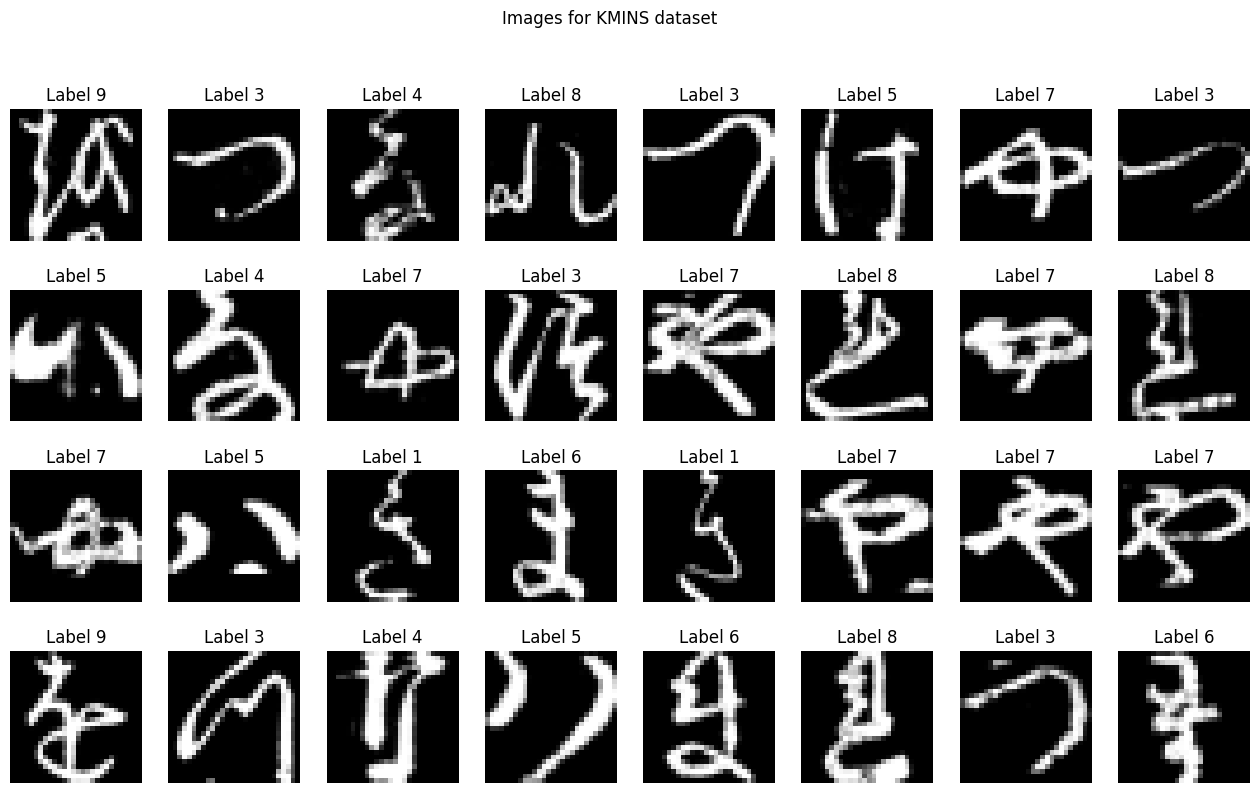

In [29]:
nrows, ncols = 4, 8
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 9))
axs = axs.flatten()
fig.suptitle("Images for KMINS dataset")
for i in range(nrows * ncols):
    X, y = train_dataset[i]
    axs[i].imshow(X.numpy().squeeze(), cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(f"Label {y}")

plt.show()

In [3]:
train_size, val_size = int(len(train_dataset) * 0.8), int(len(train_dataset) * 0.2)
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [4]:
class FullyConnectedLayer:
    def __init__(self, in_features, out_features, l2_lam=0.001):
        self.W = torch.randn(in_features, out_features) * np.sqrt(2.0 / in_features)
        self.b = torch.zeros(out_features)
        self.dW = torch.zeros_like(self.W)
        self.db = torch.zeros_like(self.b)
        self.l2_lam = l2_lam
        self.cache = None

    def forward(self, x):
        self.cache = x
        return x @ self.W + self.b

    def backward(self, dout):
        x = self.cache
        self.dW = x.T @ dout + self.l2_lam * self.W
        self.db = torch.sum(dout, axis=0)
        dx = dout @ self.W.T
        return dx

    def parameters(self):
        return [self.W, self.b]

    def gradients(self):
        return [self.dW, self.db]

In [5]:
class ReluLayer:
    def __init__(self):
        self.cache = None

    def forward(self, x):
        self.cache = x
        return torch.where(x > 0, x, torch.zeros_like(x))

    def backward(self, dout):
        mask = (self.cache > 0).float()
        return dout * mask

In [6]:
class BatchNormLayer:
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        self.eps = eps
        self.momentum = momentum
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)
        self.cache = None
        self.train_mode = True

    def forward(self, x):
        if self.train_mode:
            mu = x.mean(dim=0)
            var = x.var(dim=0, unbiased=False)
            self.running_mean = (
                1 - self.momentum
            ) * self.running_mean + self.momentum * mu
            self.running_var = (
                1 - self.momentum
            ) * self.running_var + self.momentum * var
        else:
            mu = self.running_mean
            var = self.running_var

        x_hat = (x - mu) / torch.sqrt(var + self.eps)
        out = self.gamma * x_hat + self.beta
        self.cache = (x, x_hat, mu, var)
        return out

    def backward(self, dout):
        x, x_hat, mu, var = self.cache
        N = x.shape[0]

        self.dgamma = torch.sum(dout * x_hat, axis=0)
        self.dbeta = torch.sum(dout, axis=0)

        dx_hat = dout * self.gamma
        dvar = torch.sum(
            dx_hat * (x - mu) * (-0.5) * (var + self.eps) ** (-1.5), axis=0
        )
        dmu = torch.sum(dx_hat * (-1.0 / torch.sqrt(var + self.eps)), axis=0) + dvar * (
            -2.0 / N
        ) * torch.sum(x - mu, axis=0)
        dx = dx_hat / torch.sqrt(var + self.eps) + dvar * 2.0 * (x - mu) / N + dmu / N

        return dx

    def parameters(self):
        return [self.gamma, self.beta]

    def gradients(self):
        return [self.dgamma, self.dbeta]

    def train(self):
        self.train_mode = True

    def eval(self):
        self.train_mode = False

In [7]:
class CrossEntropyLoss:
    def __init__(self):
        self.cache = None

    def forward(self, x, y):
        maxes = torch.max(x, 1, keepdim=True)[0]
        x_exp = torch.exp(x - maxes)
        probs = x_exp / torch.sum(x_exp, 1, keepdim=True)
        log_probs = torch.log(probs)
        loss = -log_probs[range(y.size(0)), y].mean()
        self.cache = (probs, y)
        return loss

    def backward(self):
        probs, y = self.cache
        batch_size = probs.shape[0]
        dlogits = probs.clone()
        dlogits[range(batch_size), y] -= 1
        dlogits /= batch_size
        return dlogits

In [8]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, dout):
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def parameters(self):
        params = []
        for layer in self.layers:
            if hasattr(layer, "parameters"):
                params.extend(layer.parameters())
        return params

    def gradients(self):
        grads = []
        for layer in self.layers:
            if hasattr(layer, "gradients"):
                grads.extend(layer.gradients())
        return grads

    def train(self):
        for layer in self.layers:
            if isinstance(layer, BatchNormLayer):
                layer.train()

    def eval(self):
        for layer in self.layers:
            if isinstance(layer, BatchNormLayer):
                layer.eval()

In [9]:
class Momentum:
    def __init__(self, params, lr=0.01, beta=0.9):
        self.params = params
        self.lr = lr
        self.beta = beta
        self.velocities = [torch.zeros_like(p) for p in params]

    def step(self, grads):
        for i in range(len(self.params)):
            self.velocities[i] = self.beta * self.velocities[i] + grads[i]
            self.params[i].data -= self.lr * self.velocities[i]

In [10]:
class Adam:
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = params
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = [torch.zeros_like(p) for p in params]
        self.v = [torch.zeros_like(p) for p in params]
        self.t = 0

    def step(self, grads):
        self.t += 1
        for i in range(len(self.params)):
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grads[i]
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grads[i] ** 2)

            m_hat = self.m[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)

            self.params[i].data -= self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

In [11]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
def create_model(in_features, out_features, hidden_size, l2_lam):
    fc1 = FullyConnectedLayer(in_features, hidden_size, l2_lam)
    relu = ReluLayer()
    bn = BatchNormLayer(hidden_size)
    fc2 = FullyConnectedLayer(hidden_size, out_features, l2_lam)
    model = NeuralNetwork([fc1, relu, bn, fc2])
    return model

In [13]:
in_features = 28 * 28
hidden_size = 128
out_features = 10
l2_lam = 0.001

num_epochs = 10

criterion = CrossEntropyLoss()

In [ ]:
def train_model(model, num_epochs, optimizer):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.view(x_batch.size(0), -1)
            logits = model.forward(x_batch)
            loss = criterion.forward(logits, y_batch)
            l2_reg = 0.0
            for layer in model.layers:
                if isinstance(layer, FullyConnectedLayer):
                    l2_reg += torch.sum(layer.W**2) * (layer.l2_lam / 2)
            total_loss_batch = loss + l2_reg
            dlogits = criterion.backward()
            model.backward(dlogits)
            optimizer.step(model.gradients())
            total_loss += total_loss_batch.item() * x_batch.size(0)
            predicted = torch.argmax(logits, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        train_loss = total_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.view(x_val.size(0), -1)
                logits = model.forward(x_val)
                loss = criterion.forward(logits, y_val)
                val_loss += loss * x_val.size(0)
                predicted = torch.argmax(logits, 1)
                correct += (predicted == y_val).sum().item()
                total += y_val.size(0)
        val_loss = val_loss / total
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(
            f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

    return train_losses, train_accs, val_losses, val_accs

In [ ]:
def model_test_score(model):
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test = x_test.view(x_test.size(0), -1)
            logits = model.forward(x_test)
            predicted = torch.argmax(logits, 1)
            test_correct += (predicted == y_test).sum().item()
            test_total += y_test.size(0)

    return test_correct / test_total

In [16]:
def compare_models(params):
    best_model = None
    best_test_score = 0
    best_config = None
    results = {}
    for param in params:
        Optim = param["optim"]
        lr = param["lr"]
        model = create_model(in_features, out_features, hidden_size, l2_lam)
        optimizer = Optim(model.parameters(), lr=lr)
        print(f"Testing optim={Optim.__name__}, lr={lr}")
        results[(Optim.__name__, lr)] = train_model(model, num_epochs, optimizer)
        if (score := model_test_score(model)) > best_test_score:
            best_test_score = score
            best_model = model
            best_config = Optim.__name__, lr

    return results, best_model, best_test_score, best_config

Сравним модели, обученные на learning rate'ах 0.1, 0.01, 0.001 и 0.0001 и на двух разных оптимизаторах: Momentum и Adam.

In [17]:
import itertools

params = [
    {"optim": optim, "lr": lr}
    for optim, lr in itertools.product([Momentum, Adam], [0.1, 0.01, 0.001, 0.0001])
]

results, best_model, best_test_score, best_config = compare_models(params)

Testing optim=Momentum, lr=0.1
Epoch 1/10
Train Loss: 0.5872, Val Loss: 0.2660, Val Acc: 0.9171
Epoch 2/10
Train Loss: 0.4473, Val Loss: 0.2514, Val Acc: 0.9225
Epoch 3/10
Train Loss: 0.4280, Val Loss: 0.2499, Val Acc: 0.9213
Epoch 4/10
Train Loss: 0.4226, Val Loss: 0.2322, Val Acc: 0.9309
Epoch 5/10
Train Loss: 0.4228, Val Loss: 0.2402, Val Acc: 0.9264
Epoch 6/10
Train Loss: 0.4316, Val Loss: 0.2248, Val Acc: 0.9288
Epoch 7/10
Train Loss: 0.4261, Val Loss: 0.2550, Val Acc: 0.9224
Epoch 8/10
Train Loss: 0.4305, Val Loss: 0.2351, Val Acc: 0.9269
Epoch 9/10
Train Loss: 0.7939, Val Loss: 0.2392, Val Acc: 0.9281
Epoch 10/10
Train Loss: 0.6741, Val Loss: 0.2283, Val Acc: 0.9271
Testing optim=Momentum, lr=0.01
Epoch 1/10
Train Loss: 0.5868, Val Loss: 0.2752, Val Acc: 0.9164
Epoch 2/10
Train Loss: 0.3654, Val Loss: 0.2248, Val Acc: 0.9308
Epoch 3/10
Train Loss: 0.3002, Val Loss: 0.2085, Val Acc: 0.9363
Epoch 4/10
Train Loss: 0.2605, Val Loss: 0.1878, Val Acc: 0.9435
Epoch 5/10
Train Loss: 0.2

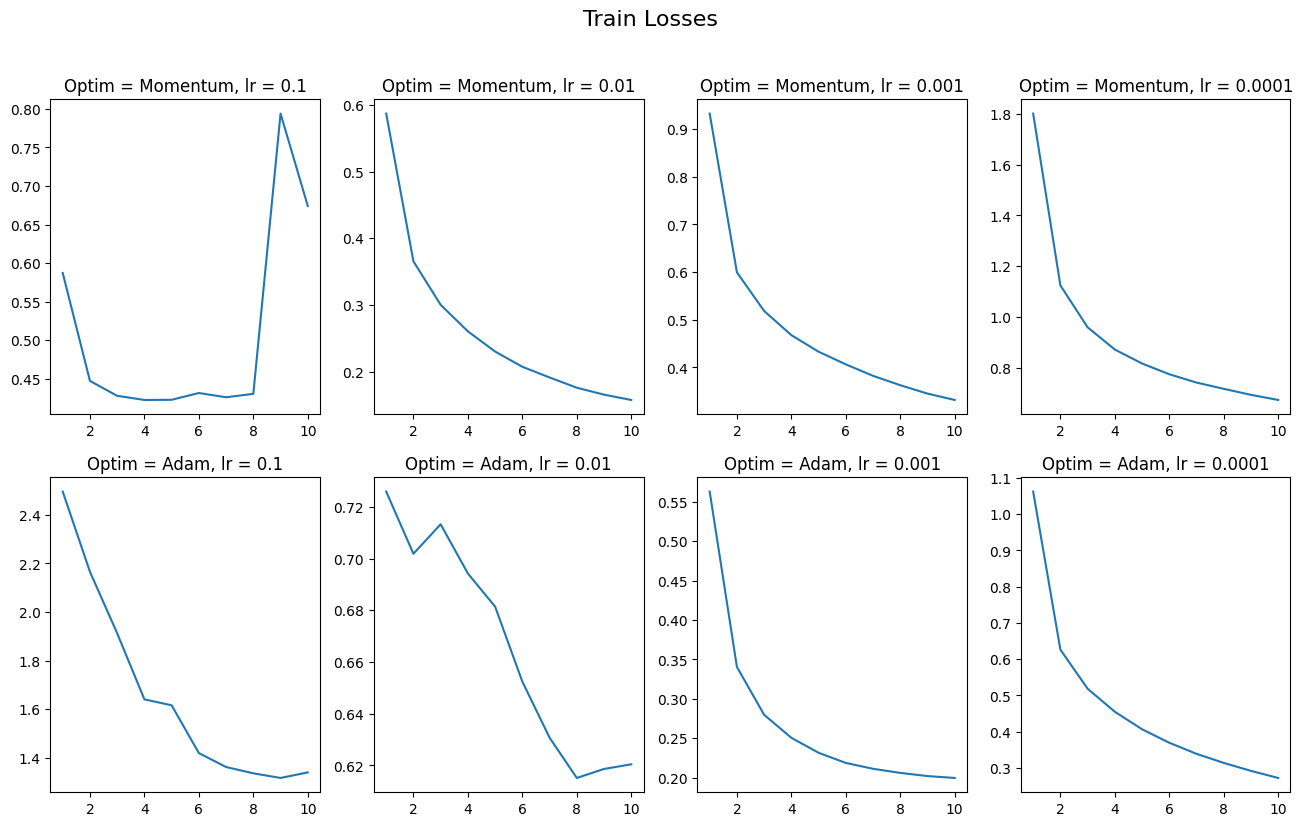

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 9))
plt.suptitle("Train Losses", fontsize=16)
for i, (optim_name, lr) in enumerate(results):
    ax = axs.flatten()[i]
    ax.set_title(f"Optim = {optim_name}, lr = {lr}")
    ax.plot(range(1, num_epochs + 1), results[(optim_name, lr)][0])
plt.show()

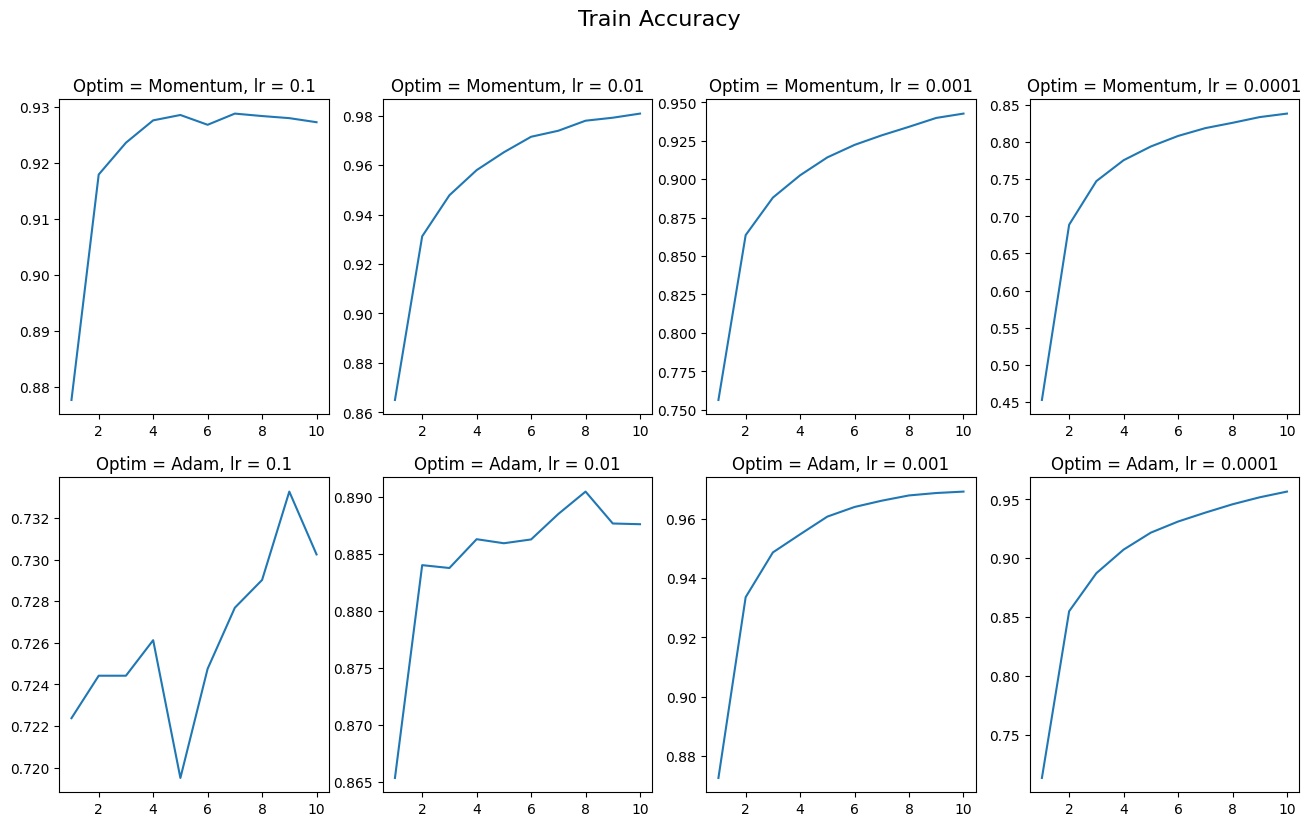

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 9))
plt.suptitle("Train Accuracy", fontsize=16)
for i, (optim_name, lr) in enumerate(results):
    ax = axs.flatten()[i]
    ax.set_title(f"Optim = {optim_name}, lr = {lr}")
    ax.plot(range(1, num_epochs + 1), results[(optim_name, lr)][1])
plt.show()

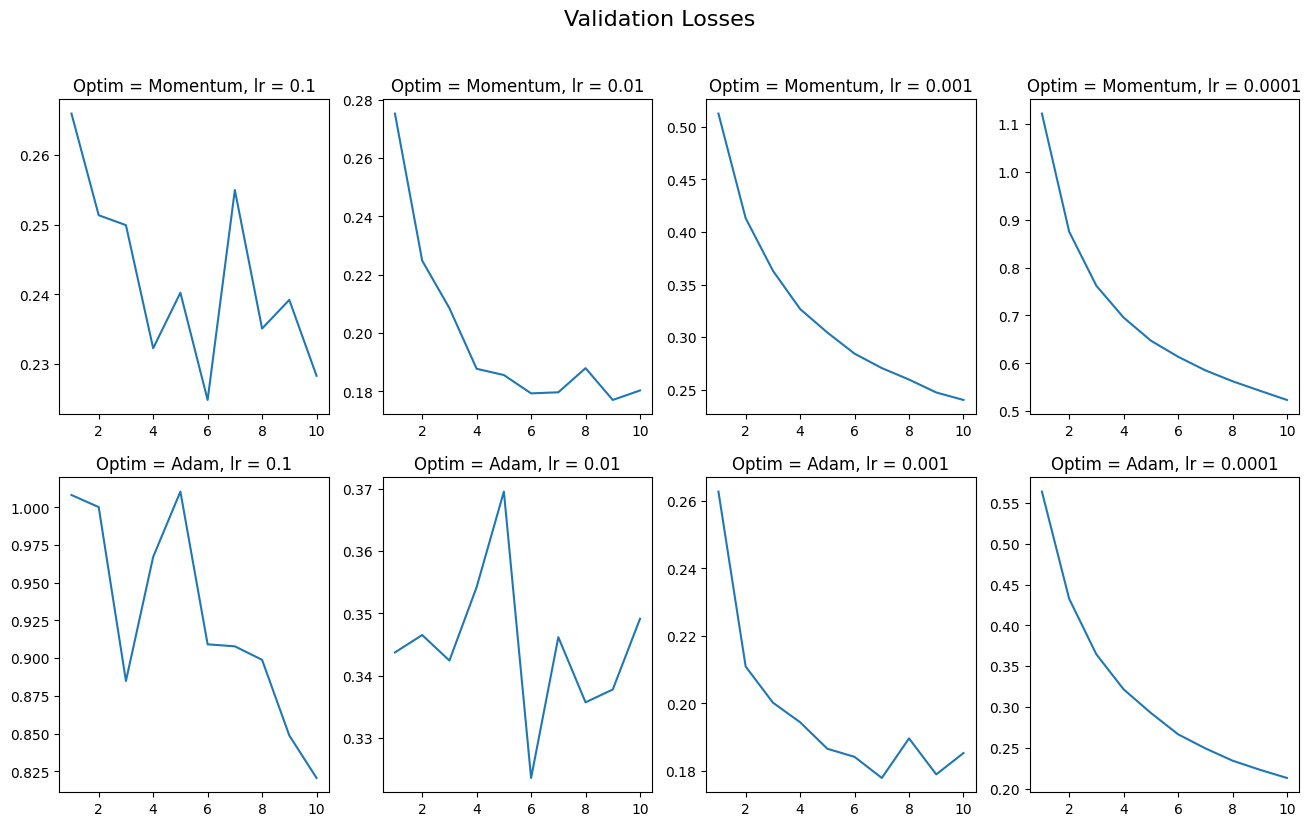

In [22]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 9))
plt.suptitle("Validation Losses", fontsize=16)
for i, (optim_name, lr) in enumerate(results):
    ax = axs.flatten()[i]
    ax.set_title(f"Optim = {optim_name}, lr = {lr}")
    ax.plot(range(1, num_epochs + 1), results[(optim_name, lr)][2])
plt.show()

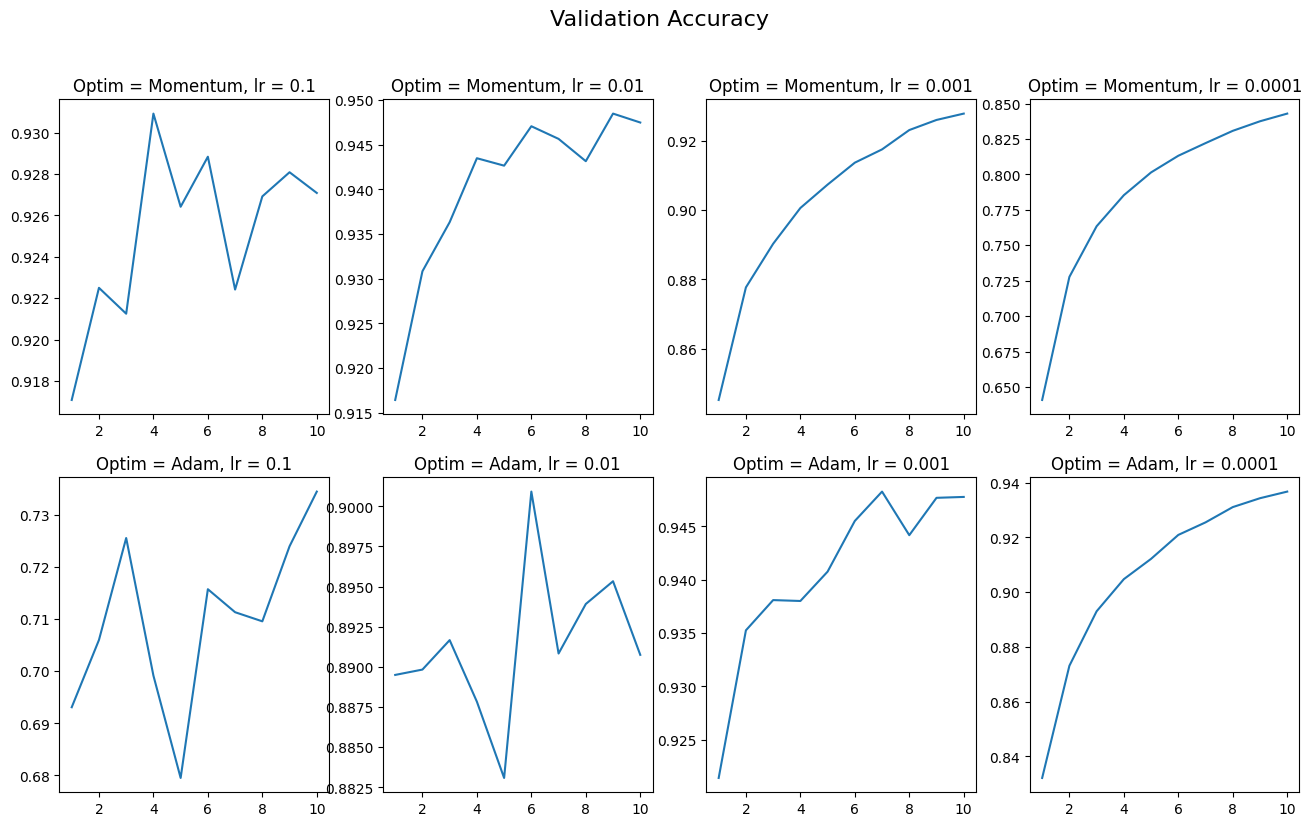

In [23]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 9))
plt.suptitle("Validation Accuracy", fontsize=16)
for i, (optim_name, lr) in enumerate(results):
    ax = axs.flatten()[i]
    ax.set_title(f"Optim = {optim_name}, lr = {lr}")
    ax.plot(range(1, num_epochs + 1), results[(optim_name, lr)][3])
plt.show()

In [19]:
best_config

('Adam', 0.001)

In [18]:
best_test_score

0.8804

Лучшей комбинацией оказалась `Adam` с `lr=0.001`. Как видно из графиков, при более низком `lr` обучение ведет себя более стабильно и предсказуемо: нет резких скачков. `Adam` очень страдает от высокого `lr` и во всех случаях его "дергает", поэтому для него рекомендуется выбирать более низкий `lr` (0.001 и ниже).
При более низком `lr` (0.001 и ниже) `Validation Loss` ведет себя стабильнее и, ровно как и `Train Loss`, постепенно опускается вниз без резких скачков вверх. C `Validation Accuracy` ситуация аналогичная.

Построим матрицу возмущения на тестовых данных

In [ ]:
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(model):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test = x_test.view(x_test.size(0), -1)
            logits = model.forward(x_test)
            predicted = torch.argmax(logits, 1)

            all_preds.append(predicted)
            all_labels.append(y_test)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=list(range(1, 11)),
        yticklabels=list(range(1, 11)),
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

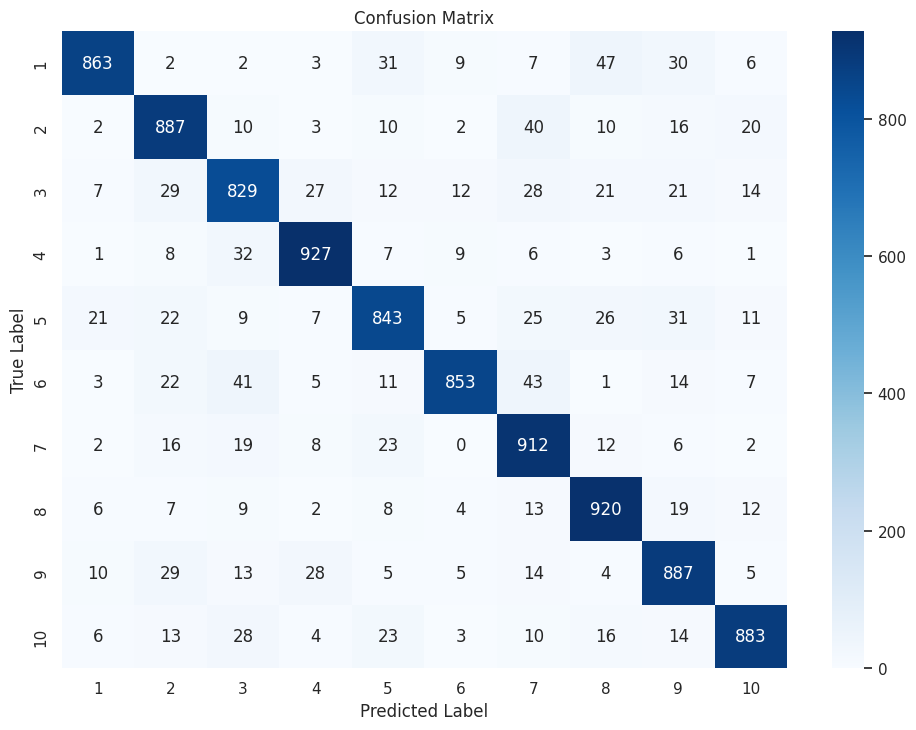

In [42]:
plot_confusion_matrix(best_model)